In [146]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from common_func import plot_decision_regions
import seaborn as sns
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image

In [147]:
#データ読み込み
df_ks = pd.read_csv("ks-projects-201801.csv", nrows=100)[['state','goal','pledged','backers']]
df_ks['state'] = df_ks['state'] == 'successful'

#質量変数をダミー変数に変換
df_ks = pd.get_dummies(df_ks)

display(df_ks)
df_ks.describe()

,state,goal,pledged,backers
0,False,1000.0,0.00,0
1,False,30000.0,2421.00,15
2,False,45000.0,220.00,3
3,False,5000.0,1.00,1
4,False,19500.0,1283.00,14
5,True,50000.0,52375.00,224
6,True,1000.0,1205.00,16
7,False,25000.0,453.00,40
8,False,125000.0,8233.00,58
9,False,65000.0,6240.57,43


,goal,pledged,backers
count,100.000000,100.000000,100.000000
mean,19796.710000,9134.102600,125.130000
std,37117.042835,20203.825442,325.564022
min,100.000000,0.000000,0.000000
25%,2875.000000,89.500000,3.000000
50%,7500.000000,1116.000000,24.500000
75%,15689.250000,8335.085000,96.250000
max,250000.000000,124998.000000,2784.000000


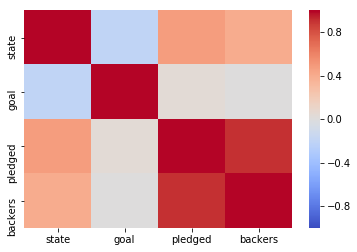

In [148]:
df_ks.corr()
sns.heatmap(df_ks.corr(), cmap='coolwarm', vmin=-1, vmax=1) 
plt.show()

In [149]:
from sklearn.ensemble import RandomForestClassifier
y = df_ks["state"].values
X = df_ks.drop('state', axis=1).values

#欠損値を0に変換
X[np.isnan(X)] = 0

#ホールドアウト法
#X = X.reshape(-1,1) # scikit-learnに入力するために整形
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.9125


[0.16018185 0.36735956 0.47245859]


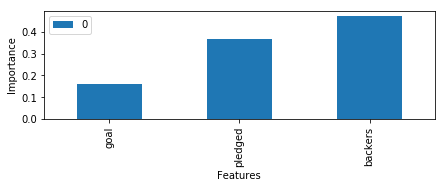

In [150]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_ks.drop('state', axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

0


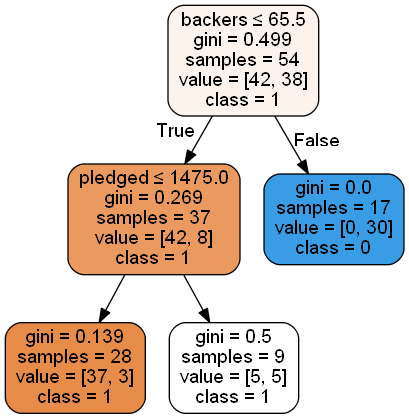

1


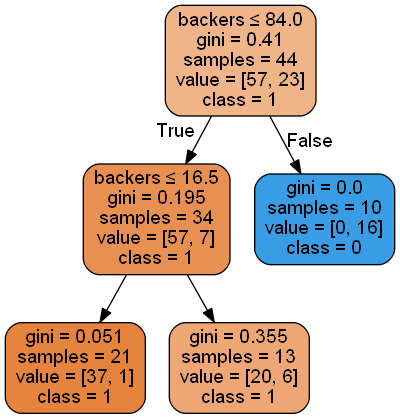

2


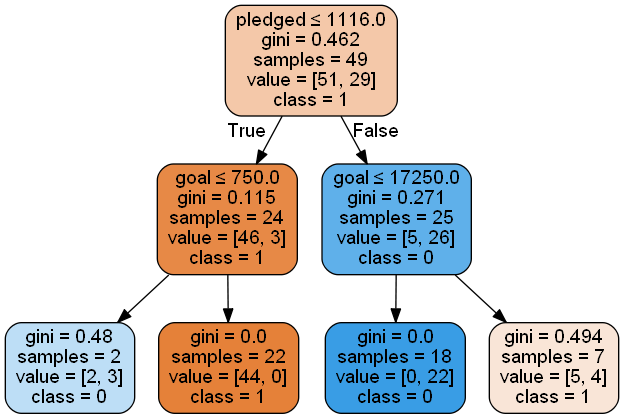

3


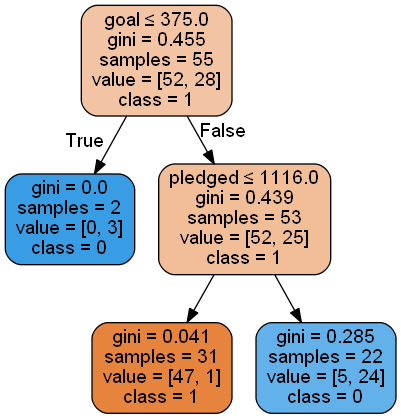

4


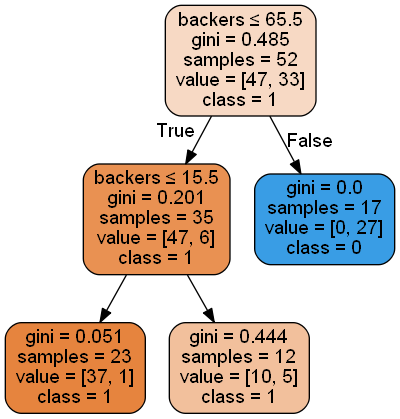

5


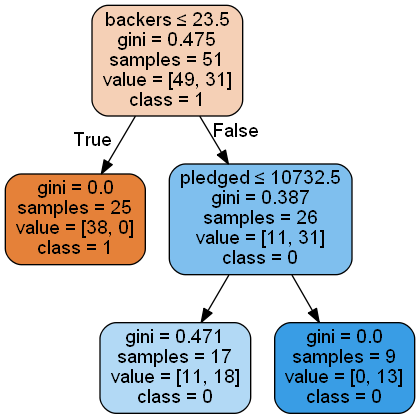

6


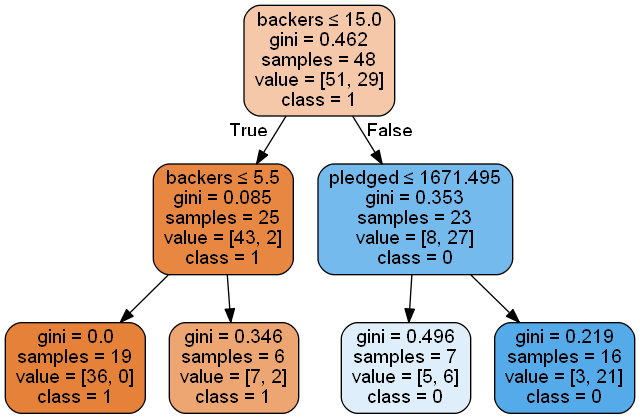

7


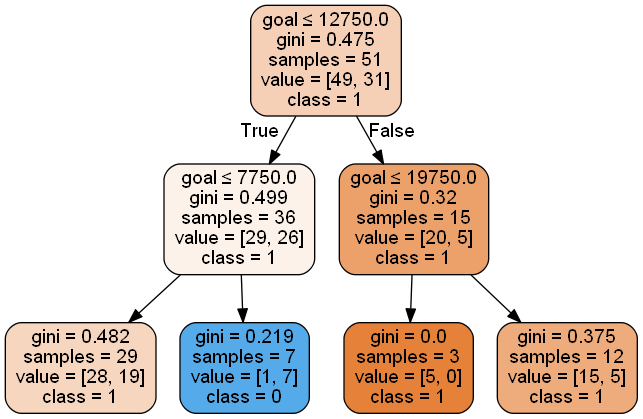

8


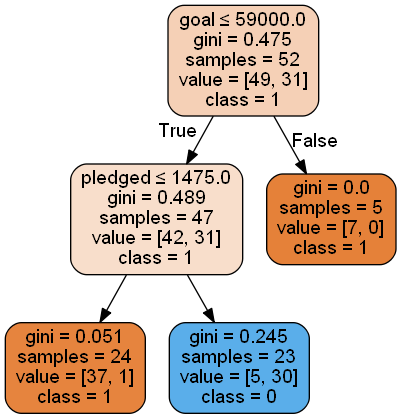

9


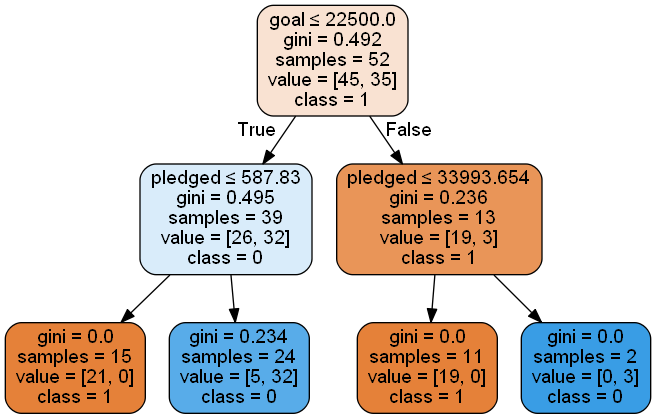

In [151]:
# 決定木の描画
for i, est in enumerate(clf.estimators_):
    print(i)
    
    # 決定木の描画
    dot_data = StringIO() #dotファイル情報の格納先
    export_graphviz(est, out_file=dot_data,  
                         feature_names=df_ks.drop('state', axis=1).columns,  
                         class_names=['1','0'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    display(Image(graph.create_png()))

In [152]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=3))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

X_train= [[6.500000e+04 6.240570e+03 4.300000e+01]
 [9.500000e+03 6.000000e+00 2.000000e+00]
 [5.000000e+04 5.757731e+04 8.400000e+02]
 [3.000000e+03 1.027000e+03 1.800000e+01]
 [5.000000e+02 2.180000e+02 6.000000e+00]
 [2.500000e+04 0.000000e+00 0.000000e+00]
 [5.000000e+03 5.870000e+02 8.000000e+00]
 [1.500000e+04 1.542500e+04 1.440000e+02]
 [5.000000e+04 1.410000e+03 3.800000e+01]
 [3.000000e+03 8.105000e+03 2.180000e+02]
 [1.950000e+04 1.283000e+03 1.400000e+01]
 [8.500000e+02 4.850000e+02 1.300000e+01]
 [2.500000e+03 0.000000e+00 0.000000e+00]
 [1.500000e+04 1.510000e+02 4.000000e+00]
 [9.500000e+03 9.660000e+03 1.210000e+02]
 [4.000000e+03 4.795000e+03 9.500000e+01]
 [4.000000e+03 8.641340e+03 1.570000e+02]
 [2.500000e+04 4.530000e+02 4.000000e+01]
 [1.100000e+04 1.105500e+04 5.100000e+01]
 [7.500000e+03 8.157010e+03 1.640000e+02]
 [2.500000e+03 1.000000e+00 1.000000e+00]
 [2.500000e+02 2.500000e+02 7.000000e+00]
 [8.700000e+04 2.030000e+03 1.500000e+01]
 [1.000000e+04 8.800000e+

Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 0s 2ms/sample - loss: 5425.7132 - acc: 0.5875 - val_loss: 0.6910 - val_acc: 0.5500
Epoch 2/50
80/80 [==============================] - 0s 268us/sample - loss: 0.6893 - acc: 0.5875 - val_loss: 0.6892 - val_acc: 0.5500
Epoch 3/50
80/80 [==============================] - 0s 163us/sample - loss: 0.6846 - acc: 0.5875 - val_loss: 0.6883 - val_acc: 0.5500
Epoch 4/50
80/80 [==============================] - 0s 205us/sample - loss: 0.6811 - acc: 0.5875 - val_loss: 0.6881 - val_acc: 0.5500
Epoch 5/50
80/80 [==============================] - 0s 177us/sample - loss: 0.6795 - acc: 0.5875 - val_loss: 0.6883 - val_acc: 0.5500
Epoch 6/50
80/80 [==============================] - 0s 150us/sample - loss: 0.6784 - acc: 0.5875 - val_loss: 0.6886 - val_acc: 0.5500
Epoch 7/50
80/80 [==============================] - 0s 188us/sample - loss: 0.6779 - acc: 0.5875 - val_loss: 0.6891 - val_acc: 0.5500
Epoch 8/50
80/80 

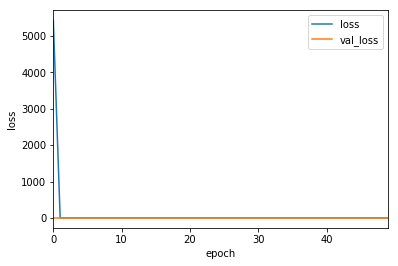

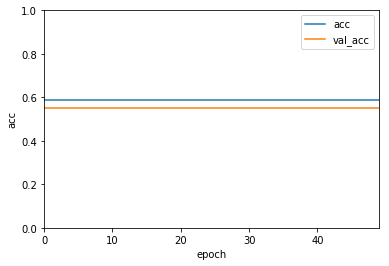

In [153]:
# 計算の実行
fit = model.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

In [154]:
weights = model.get_weights()
for i in range(len(weights)):
    print("weights[%s]="%i)
    print(weights[i])
    print("num:",weights[i].flatten().shape[0])
    print()

weights[0]=
[[-2.5495862e+03  1.1961713e+03 -1.6461105e+03 -1.8821017e+03
   5.3058807e+02 -9.6681525e+02]
 [-9.8306900e+01  4.6221081e+01 -6.2809090e+01 -7.2228172e+01
   5.7917538e+01 -3.3300102e+01]
 [-1.2382588e+00  1.5104694e-02 -1.0367844e+00 -1.4389139e+00
   6.7792332e-01 -1.8397535e-01]]
num: 18

weights[1]=
[-0.09577645  0.04494622 -0.06232085 -0.07025715  0.02808589 -0.02977517]
num: 6

weights[2]=
[[-781.42035   -543.9848    -910.806      -95.69297   -648.6348   ]
 [ -81.201935   -55.83658    -93.95825     -9.652045   -67.61126  ]
 [-269.34225   -187.21646   -314.29468    -33.268578  -223.76978  ]
 [-644.6881    -448.62448   -750.4457     -78.202034  -534.01074  ]
 [ -12.941154    -8.663831   -15.077913    -1.0665008  -10.21275  ]
 [-117.6829     -81.41826   -136.83739    -13.837663   -96.94848  ]]
num: 30

weights[3]=
[-0.06314071 -0.04395241 -0.07358222 -0.00701391 -0.05239199]
num: 5

weights[4]=
[[ 257.59592 -257.0608 ]
 [ 382.91168 -382.83585]
 [ 618.03217 -618.2668 ]


In [155]:
from tensorflow.compat.v1.keras.models import load_model

# 保存
model.save('my_model.h5')
del model

# 読み込み
model = load_model('my_model.h5')

In [156]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)